In [1]:
from __future__ import annotations
import csv
import json
import re
from dataclasses import dataclass
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def find_repo_root(start: Path | None = None) -> Path:
    """Walk upward until Cargo.toml is found to anchor relative paths."""
    current = (start or Path.cwd()).resolve()
    for candidate in [current, *current.parents]:
        if (candidate / "Cargo.toml").exists():
            return candidate
    raise RuntimeError("Could not locate repository root (missing Cargo.toml)")


REPO_ROOT = find_repo_root()
EVAL_DIR = REPO_ROOT / "python" / "evaluation"
REFERENCE_DIR = EVAL_DIR / "reference-data"

@dataclass
class BandData:
    distances: List[float]
    bands: List[List[float]]
    k_nodes: List[dict]

def load_mpb(path: Path) -> BandData:
    data = json.loads(path.read_text())
    distances = [kp["distance"] for kp in data["k_path"]]
    bands = [list(band) for band in zip(*data["bands"])]
    return BandData(distances, bands, data.get("k_nodes", []))

def load_mpb2d_csv(path: Path) -> BandData:
    with path.open() as handle:
        reader = csv.DictReader(handle)
        distances: List[float] = []
        band_columns = [name for name in reader.fieldnames if name.startswith("band")]
        bands = [[] for _ in band_columns]
        for row in reader:
            distances.append(float(row["k_distance"]))
            for idx, column in enumerate(band_columns):
                value = row[column]
                bands[idx].append(float(value) if value else float("nan"))
    return BandData(distances, bands, [])

In [2]:
DATASET_FILES = {
    ("mpb", "TE"): REFERENCE_DIR / "hex_te_eps13_r0p3_res24_k6_b8_mpb.json",
    ("mpb", "TM"): REFERENCE_DIR / "hex_tm_eps13_r0p3_res24_k6_b8_mpb.json",
    ("mpb2d", "TE"): REFERENCE_DIR / "hex_te_eps13_r0p3_res24_k6_b8_mpb2d.csv",
    ("mpb2d", "TM"): REFERENCE_DIR / "hex_tm_eps13_r0p3_res24_k6_b8_mpb2d.csv",
}

DATASET_LOADERS = {
    "mpb": load_mpb,
    "mpb2d": load_mpb2d_csv,
}

POL_COLORS = {"TE": "tab:orange", "TM": "tab:blue"}
PANEL_TITLES = {"mpb": "MPB (reference)", "mpb2d": "mpb2d-cli"}

def load_dataset(dataset: str, pol: str) -> BandData:
    key = dataset.lower()
    pol_key = pol.upper()
    path = DATASET_FILES[(key, pol_key)]
    loader = DATASET_LOADERS[key]
    return loader(path)

def extract_node_metadata():
    try:
        ref = load_dataset("mpb", "TE")
    except FileNotFoundError:
        return [], []
    if not ref.k_nodes:
        return [], []
    positions = [node.get("distance", idx) for idx, node in enumerate(ref.k_nodes)]
    labels = [node.get("label", f"K{idx}") for idx, node in enumerate(ref.k_nodes)]
    return positions, labels

node_positions, node_labels = extract_node_metadata()

def align_distances(distances):
    if not distances:
        return []
    values = np.asarray(distances, dtype=float)
    values = values - values[0]
    span = values[-1] if values[-1] != 0 else 1.0
    target_span = node_positions[-1] if node_positions else span
    scale = target_span / span if span else 1.0
    return (values * scale).tolist()

In [3]:
PIPELINE_DIRS = {
    "TE": REFERENCE_DIR / "hex_te_eps13_r0p3_res24_k6_b8_pipeline",
    "TM": REFERENCE_DIR / "hex_tm_eps13_r0p3_res24_k6_b8_pipeline",
}

REAL_FILENAME = "epsilon_real.csv"
RAW_REAL_FILENAME = "epsilon_real_raw.csv"
FOURIER_FILENAME = "epsilon_fourier.csv"
FFT_WORKSPACE_RAW = "fft_workspace_raw_k000.csv"
FFT_WORKSPACE_REPORT = "fft_workspace_report_k000.json"


def _reshape_grid(df: pd.DataFrame, value_column: str) -> np.ndarray:
    ordered = df.sort_values(["iy", "ix"])
    nx = int(ordered["ix"].max()) + 1
    ny = int(ordered["iy"].max()) + 1
    return ordered[value_column].to_numpy().reshape(ny, nx)


def _axis_coords(df: pd.DataFrame, index_col: str, value_col: str) -> np.ndarray:
    return (
        df[[index_col, value_col]]
        .drop_duplicates(subset=index_col)
        .sort_values(index_col)[value_col]
        .to_numpy()
    )


def _coerce_numeric(series: pd.Series) -> pd.Series:
    cleaned = series.astype(str).str.replace(")", "", regex=False).str.strip()
    return pd.to_numeric(cleaned, errors="coerce")


def load_real_space_eps(pol: str, variant: str = "smoothed"):
    filename = REAL_FILENAME if variant == "smoothed" else RAW_REAL_FILENAME
    path = PIPELINE_DIRS[pol] / filename
    if not path.exists() and variant != "smoothed":
        path = PIPELINE_DIRS[pol] / REAL_FILENAME
    df = pd.read_csv(path)
    grid = _reshape_grid(df, "epsilon")
    xs = _axis_coords(df, "ix", "x")
    ys = _axis_coords(df, "iy", "y")
    return xs, ys, grid


def load_fourier_eps(pol: str):
    df = pd.read_csv(PIPELINE_DIRS[pol] / FOURIER_FILENAME)
    df["real"] = _coerce_numeric(df["real"])
    df["imag"] = _coerce_numeric(df["imag"])
    df["gx"] = _coerce_numeric(df["gx"])
    df["gy"] = _coerce_numeric(df["gy"])
    df = df.assign(eps_complex=df["real"] + 1j * df["imag"])
    grid = _reshape_grid(df, "eps_complex")
    gx = _axis_coords(df, "ix", "gx")
    gy = _axis_coords(df, "iy", "gy")
    return gx, gy, grid


def load_fft_workspace_raw(pol: str):
    path = PIPELINE_DIRS[pol] / FFT_WORKSPACE_RAW
    if not path.exists():
        raise FileNotFoundError(path)
    return pd.read_csv(path)


def load_fft_workspace_report(pol: str):
    path = PIPELINE_DIRS[pol] / FFT_WORKSPACE_REPORT
    if not path.exists():
        raise FileNotFoundError(path)
    return json.loads(path.read_text())


OPERATOR_SNAPSHOT_REGEX = re.compile(
    r"operator_snapshot_(?P<pol>[a-z]+)_k(?P<k>\d{3})_mode(?P<mode>\d{2})(?P<spectrum>_spectrum)?\.csv"
)


def _operator_snapshot_stem(pol: str, k_index: int, mode_index: int) -> str:
    return f"operator_snapshot_{pol.lower()}_k{k_index:03}_mode{mode_index:02}"


def _operator_snapshot_path(pol: str, k_index: int, mode_index: int, spectrum: bool = False) -> Path:
    suffix = "_spectrum" if spectrum else ""
    filename = f"{_operator_snapshot_stem(pol, k_index, mode_index)}{suffix}.csv"
    return PIPELINE_DIRS[pol] / filename


def load_operator_snapshot(pol: str, k_index: int = 0, mode_index: int = 1) -> pd.DataFrame:
    path = _operator_snapshot_path(pol, k_index, mode_index, spectrum=False)
    if not path.exists():
        raise FileNotFoundError(path)
    return pd.read_csv(path)


def load_operator_spectrum(pol: str, k_index: int = 0, mode_index: int = 1) -> pd.DataFrame:
    path = _operator_snapshot_path(pol, k_index, mode_index, spectrum=True)
    if not path.exists():
        raise FileNotFoundError(path)
    return pd.read_csv(path)


def load_iteration_trace(pol: str, k_index: int = 0) -> pd.DataFrame:
    filename = f"operator_iteration_trace_{pol.lower()}_k{k_index:03}.csv"
    path = PIPELINE_DIRS[pol] / filename
    if not path.exists():
        raise FileNotFoundError(path)
    return pd.read_csv(path)


def list_operator_snapshots(pol: str):
    matches = set()
    pattern = f"operator_snapshot_{pol.lower()}_k*_mode*.csv"
    for path in PIPELINE_DIRS[pol].glob(pattern):
        if path.name.endswith("_spectrum.csv"):
            continue
        match = OPERATOR_SNAPSHOT_REGEX.match(path.name)
        if not match:
            continue
        matches.add((int(match.group("k")), int(match.group("mode"))))
    return sorted(matches)

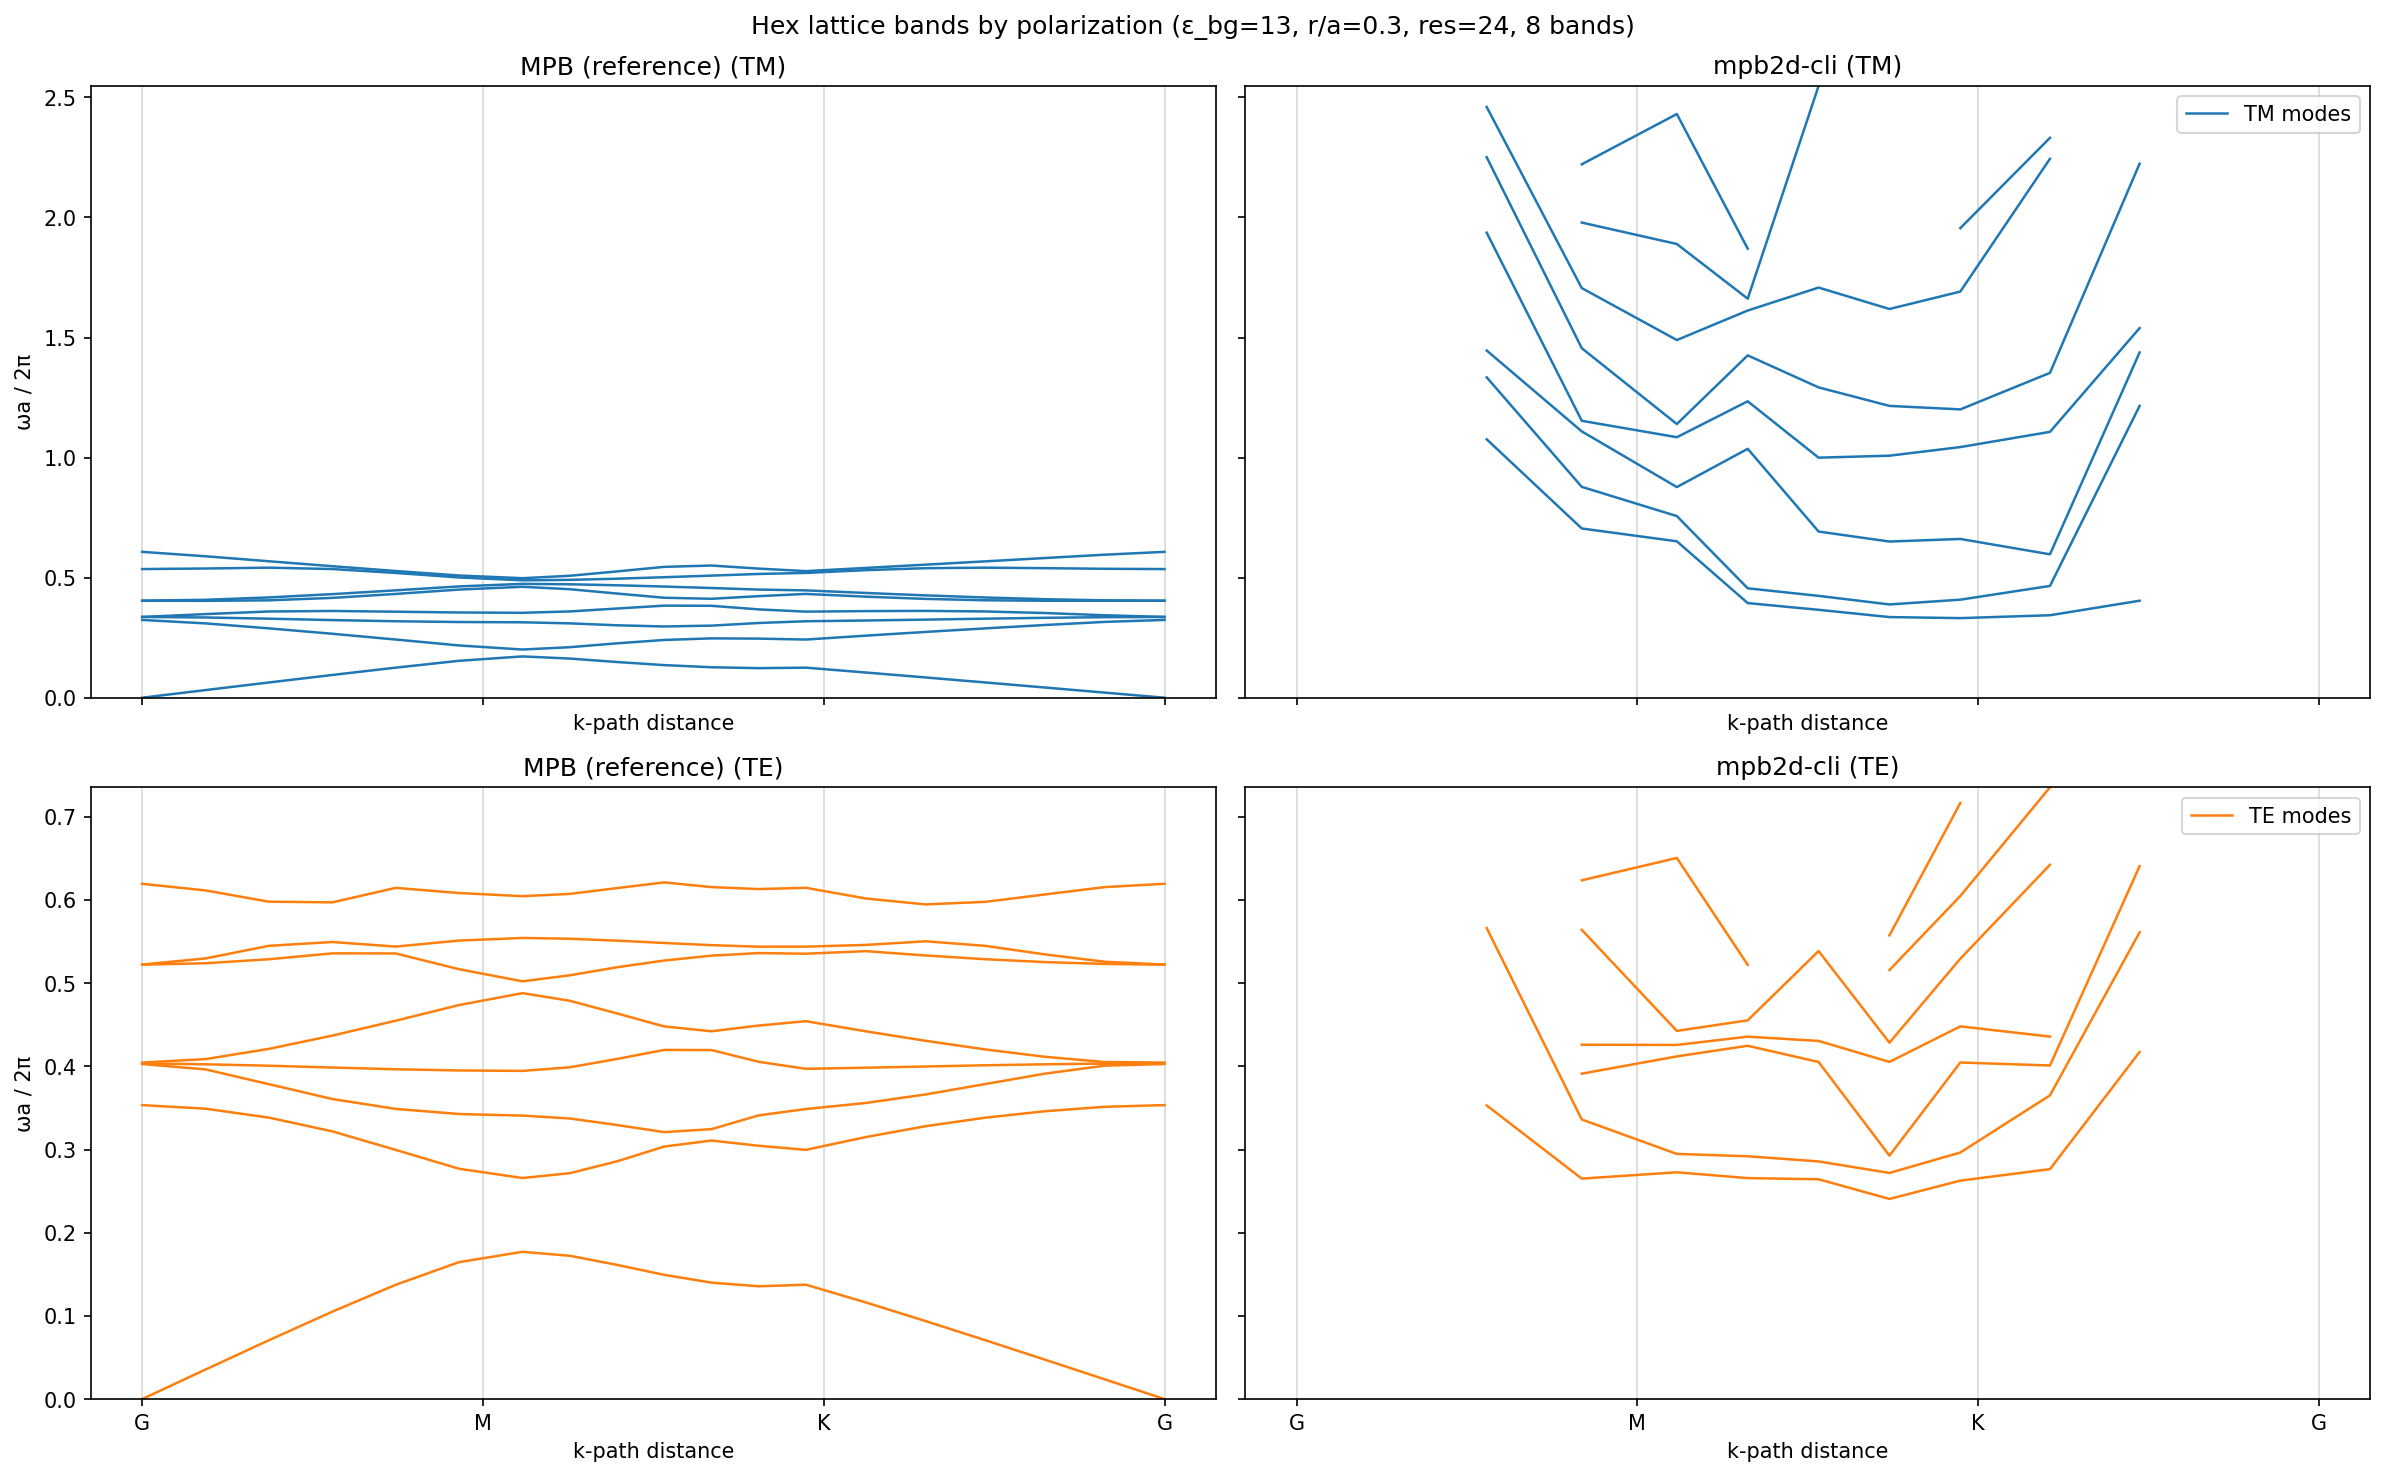

In [4]:
pol_order = ["TM", "TE"]
dataset_order = ["mpb", "mpb2d"]

fig, axes = plt.subplots(
    2,
    2,
    figsize=(16, 10),
    sharex=True,
    sharey="row",
    dpi=150,
 )

row_limits = {pol: [float("inf"), float("-inf")] for pol in pol_order}

for row_idx, pol in enumerate(pol_order):
    for col_idx, dataset in enumerate(dataset_order):
        ax = axes[row_idx, col_idx]
        data = load_dataset(dataset, pol)
        distances = align_distances(data.distances)

        for band_idx, band in enumerate(data.bands):
            label = f"{pol} modes" if band_idx == 0 else None
            ax.plot(
                distances,
                band,
                color=POL_COLORS[pol],
                linewidth=1.2,
                label=label,
            )

            finite_vals = [value for value in band if not (value != value)]
            if finite_vals:
                row_limits[pol][0] = min(row_limits[pol][0], min(finite_vals))
                row_limits[pol][1] = max(row_limits[pol][1], max(finite_vals))

        if node_positions:
            ax.set_xticks(node_positions)
            ax.set_xticklabels(node_labels)
            for pos in node_positions:
                ax.axvline(pos, color="0.85", linewidth=0.8, zorder=0)

        ax.set_title(f"{PANEL_TITLES[dataset]} ({pol})")
        ax.set_xlabel("k-path distance")
        if col_idx == 0:
            ax.set_ylabel("ωa / 2π")

    axes[row_idx, 1].legend(loc="upper right")

for row_idx, pol in enumerate(pol_order):
    y_min, y_max = row_limits[pol]
    if y_min < y_max:
        for ax in axes[row_idx]:
            ax.set_ylim(y_min, y_max)

fig.suptitle("Hex lattice bands by polarization (ε_bg=13, r/a=0.3, res=24, 8 bands)")
fig.tight_layout()
plt.show()


Raw real-space ε statistics:
  TM: min=1.000, max=13.000, avg=8.625
  TE: min=1.000, max=13.000, avg=8.625


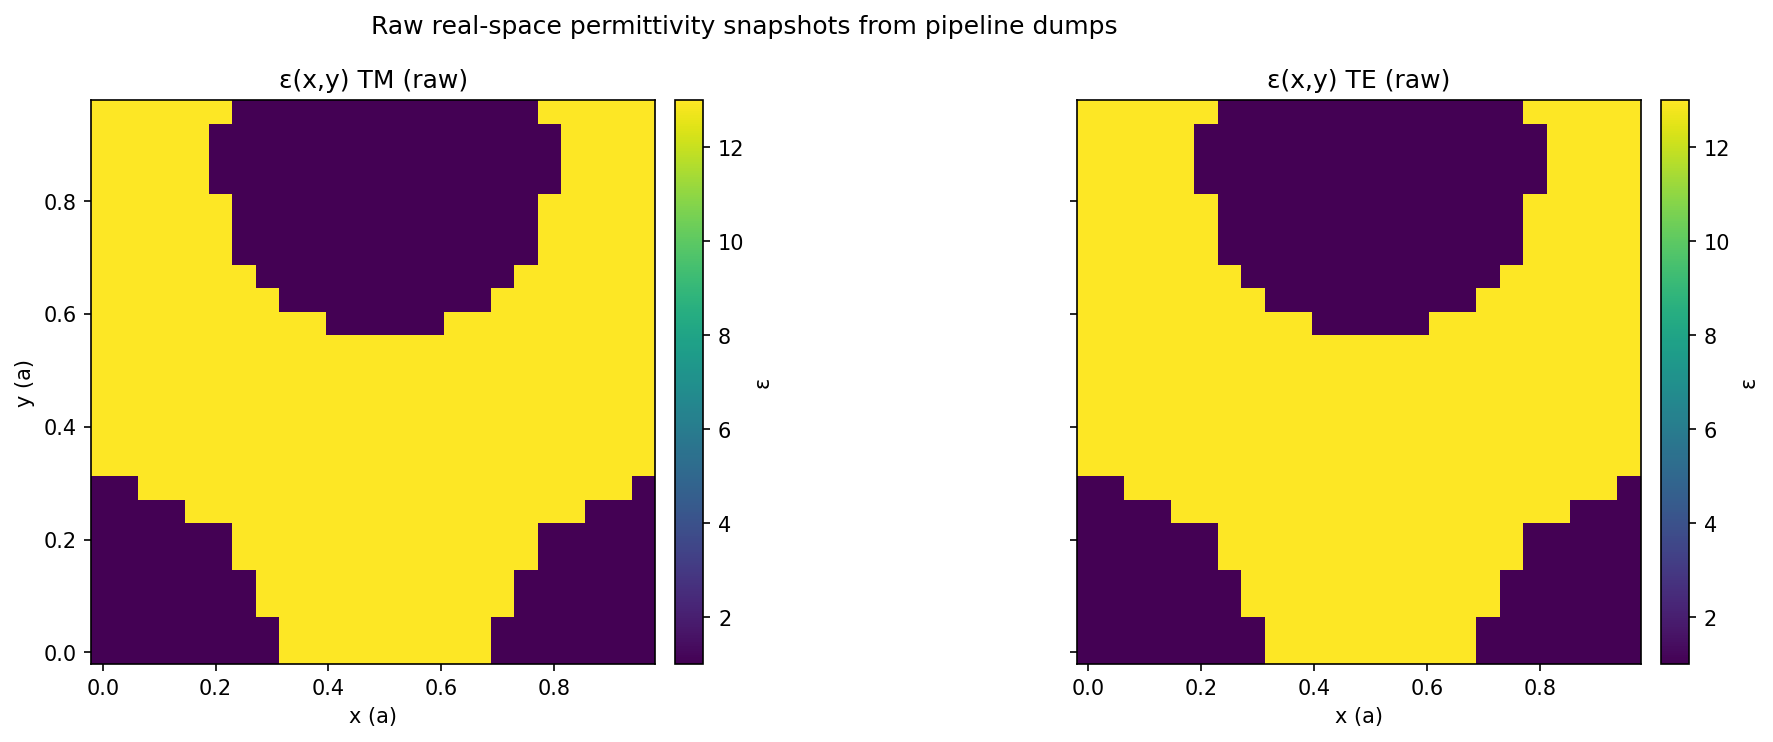

In [5]:
raw_snapshots = {pol: load_real_space_eps(pol, variant="raw") for pol in ["TM", "TE"]}

print("Raw real-space ε statistics:")
for pol, (_, _, eps_grid) in raw_snapshots.items():
    finite = eps_grid[np.isfinite(eps_grid)]
    print(
        f"  {pol}: min={finite.min():.3f}, max={finite.max():.3f}, avg={finite.mean():.3f}"
    )

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True, dpi=150)
for idx, pol in enumerate(["TM", "TE"]):
    xs, ys, eps_grid = raw_snapshots[pol]
    mesh = axes[idx].pcolormesh(
        xs,
        ys,
        eps_grid,
        shading="nearest",
        cmap="viridis",
    )
    axes[idx].set_title(f"ε(x,y) {pol} (raw)")
    axes[idx].set_xlabel("x (a)")
    axes[idx].set_aspect("equal")
    if idx == 0:
        axes[idx].set_ylabel("y (a)")
    fig.colorbar(mesh, ax=axes[idx], fraction=0.046, pad=0.02, label="ε")

fig.suptitle("Raw real-space permittivity snapshots from pipeline dumps")
fig.tight_layout()
plt.show()

Smoothed real-space ε statistics:
  TM: min=1.000, max=13.000, avg=8.672
  TE: min=1.000, max=13.000, avg=8.672


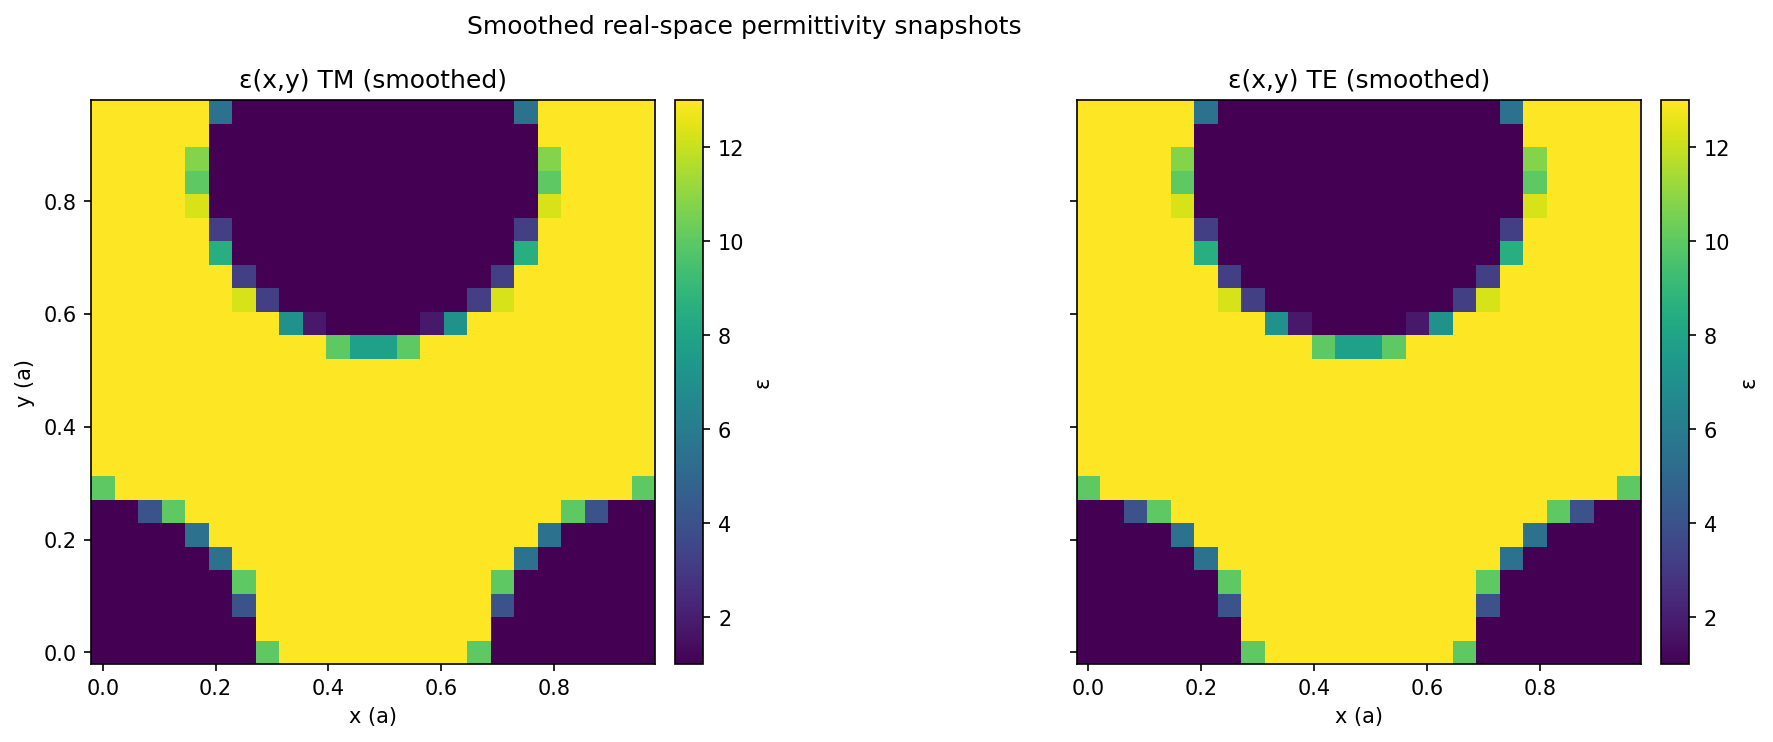

In [6]:
smoothed_snapshots = {pol: load_real_space_eps(pol, variant="smoothed") for pol in ["TM", "TE"]}

print("Smoothed real-space ε statistics:")
for pol, (_, _, eps_grid) in smoothed_snapshots.items():
    finite = eps_grid[np.isfinite(eps_grid)]
    print(
        f"  {pol}: min={finite.min():.3f}, max={finite.max():.3f}, avg={finite.mean():.3f}"
    )

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True, dpi=150)
for idx, pol in enumerate(["TM", "TE"]):
    xs, ys, eps_grid = smoothed_snapshots[pol]
    mesh = axes[idx].pcolormesh(
        xs,
        ys,
        eps_grid,
        shading="nearest",
        cmap="viridis",
    )
    axes[idx].set_title(f"ε(x,y) {pol} (smoothed)")
    axes[idx].set_xlabel("x (a)")
    axes[idx].set_aspect("equal")
    if idx == 0:
        axes[idx].set_ylabel("y (a)")
    fig.colorbar(mesh, ax=axes[idx], fraction=0.046, pad=0.02, label="ε")

fig.suptitle("Smoothed real-space permittivity snapshots")
fig.tight_layout()
plt.show()

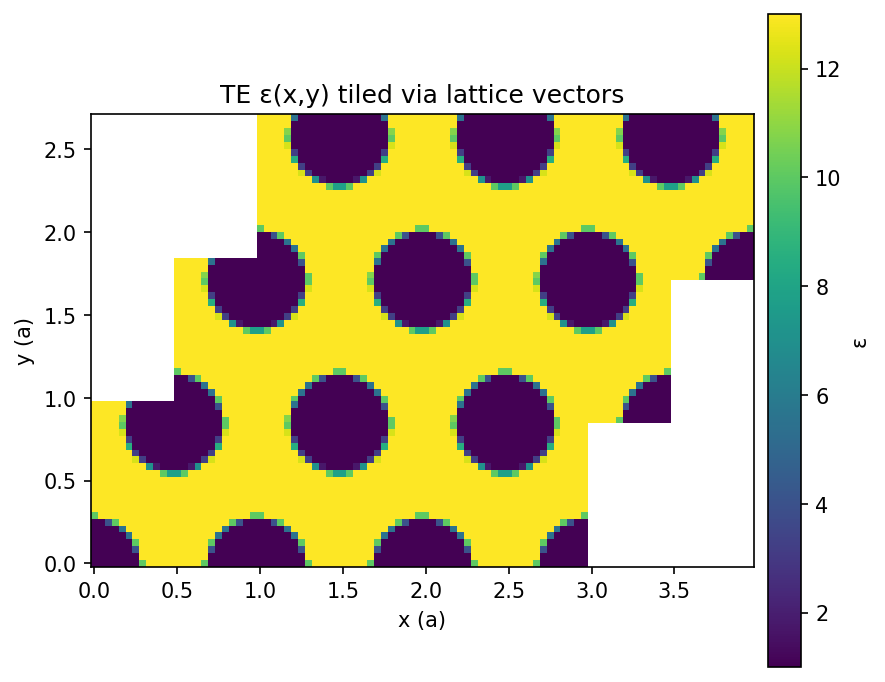

In [7]:
tile_factor = 3
pol = "TE"
xs, ys, eps_grid = smoothed_snapshots[pol]
base_x, base_y = np.meshgrid(xs, ys)
hex_a1 = np.array([1.0, 0.0])
hex_a2 = np.array([0.5, np.sqrt(3.0) / 2.0])
shifts = [i * hex_a1 + j * hex_a2 for i in range(tile_factor) for j in range(tile_factor)]

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
pcm = None
for shift in shifts:
    pcm = ax.pcolormesh(
        base_x + shift[0],
        base_y + shift[1],
        eps_grid,
        shading="nearest",
        cmap="viridis",
    )
ax.set_title(f"{pol} ε(x,y) tiled via lattice vectors")
ax.set_xlabel("x (a)")
ax.set_ylabel("y (a)")
ax.set_aspect("equal")
if pcm is not None:
    fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.02, label="ε")
fig.tight_layout()
plt.show()

Fourier-space ε(G) magnitude statistics:
  TM: max=4995.000, median=26.572, 95th pct=194.206
  TE: max=4995.000, median=26.572, 95th pct=194.206


/tmp/ipykernel_11474/1897726606.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mag_plot = axes[row_idx, 0].pcolormesh(
/tmp/ipykernel_11474/1897726606.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  phase_plot = axes[row_idx, 1].pcolormesh(


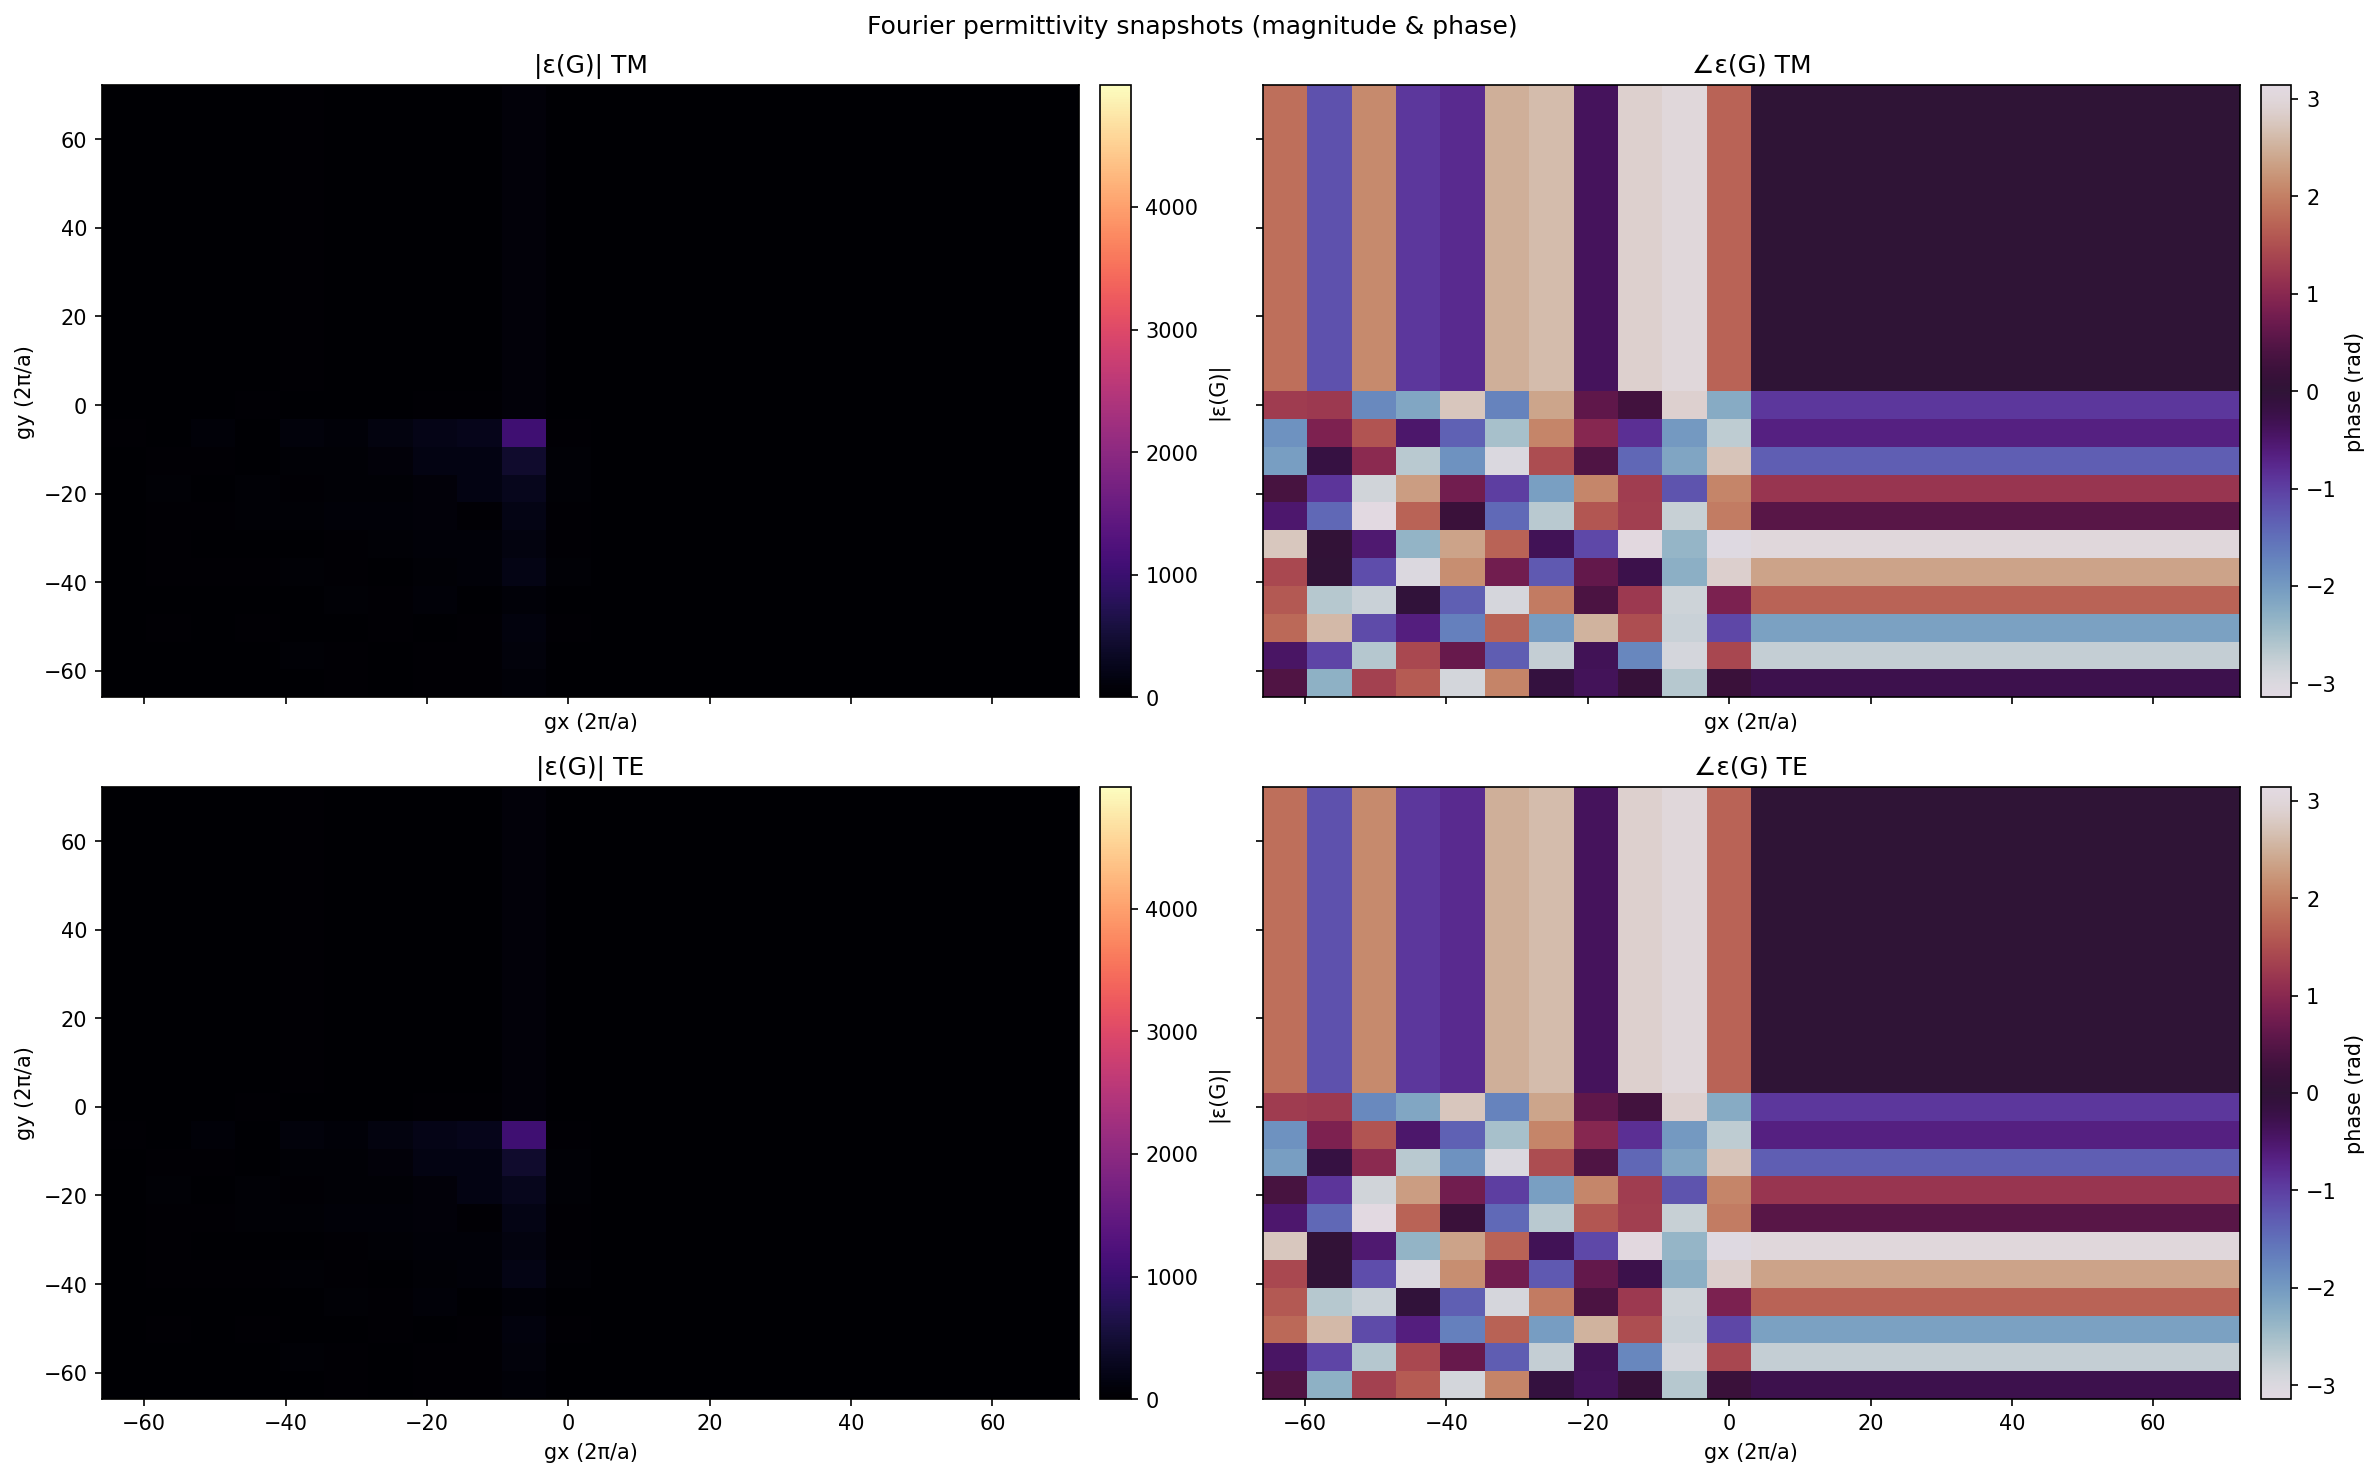

In [8]:
fourier_snapshots = {pol: load_fourier_eps(pol) for pol in ["TM", "TE"]}

print("Fourier-space ε(G) magnitude statistics:")
for pol, (_, _, eps_grid) in fourier_snapshots.items():
    mag = np.abs(eps_grid)
    print(
        f"  {pol}: max={mag.max():.3f}, median={np.median(mag):.3f}, 95th pct={np.percentile(mag, 95):.3f}"
    )

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex="col", sharey="row", dpi=150)
for row_idx, pol in enumerate(["TM", "TE"]):
    gx, gy, eps_grid = fourier_snapshots[pol]
    grid_x, grid_y = np.meshgrid(gx, gy)
    magnitude = np.abs(eps_grid)
    phase = np.angle(eps_grid)

    mag_plot = axes[row_idx, 0].pcolormesh(
        grid_x,
        grid_y,
        magnitude,
        shading="nearest",
        cmap="magma",
    )
    axes[row_idx, 0].set_title(f"|ε(G)| {pol}")
    axes[row_idx, 0].set_ylabel("gy (2π/a)")
    axes[row_idx, 0].set_xlabel("gx (2π/a)")
    fig.colorbar(mag_plot, ax=axes[row_idx, 0], fraction=0.046, pad=0.02, label="|ε(G)|")

    phase_plot = axes[row_idx, 1].pcolormesh(
        grid_x,
        grid_y,
        phase,
        shading="nearest",
        cmap="twilight",
        vmin=-np.pi,
        vmax=np.pi,
    )
    axes[row_idx, 1].set_title(f"∠ε(G) {pol}")
    axes[row_idx, 1].set_xlabel("gx (2π/a)")
    fig.colorbar(phase_plot, ax=axes[row_idx, 1], fraction=0.046, pad=0.02, label="phase (rad)")

fig.suptitle("Fourier permittivity snapshots (magnitude & phase)")
fig.tight_layout()
plt.show()

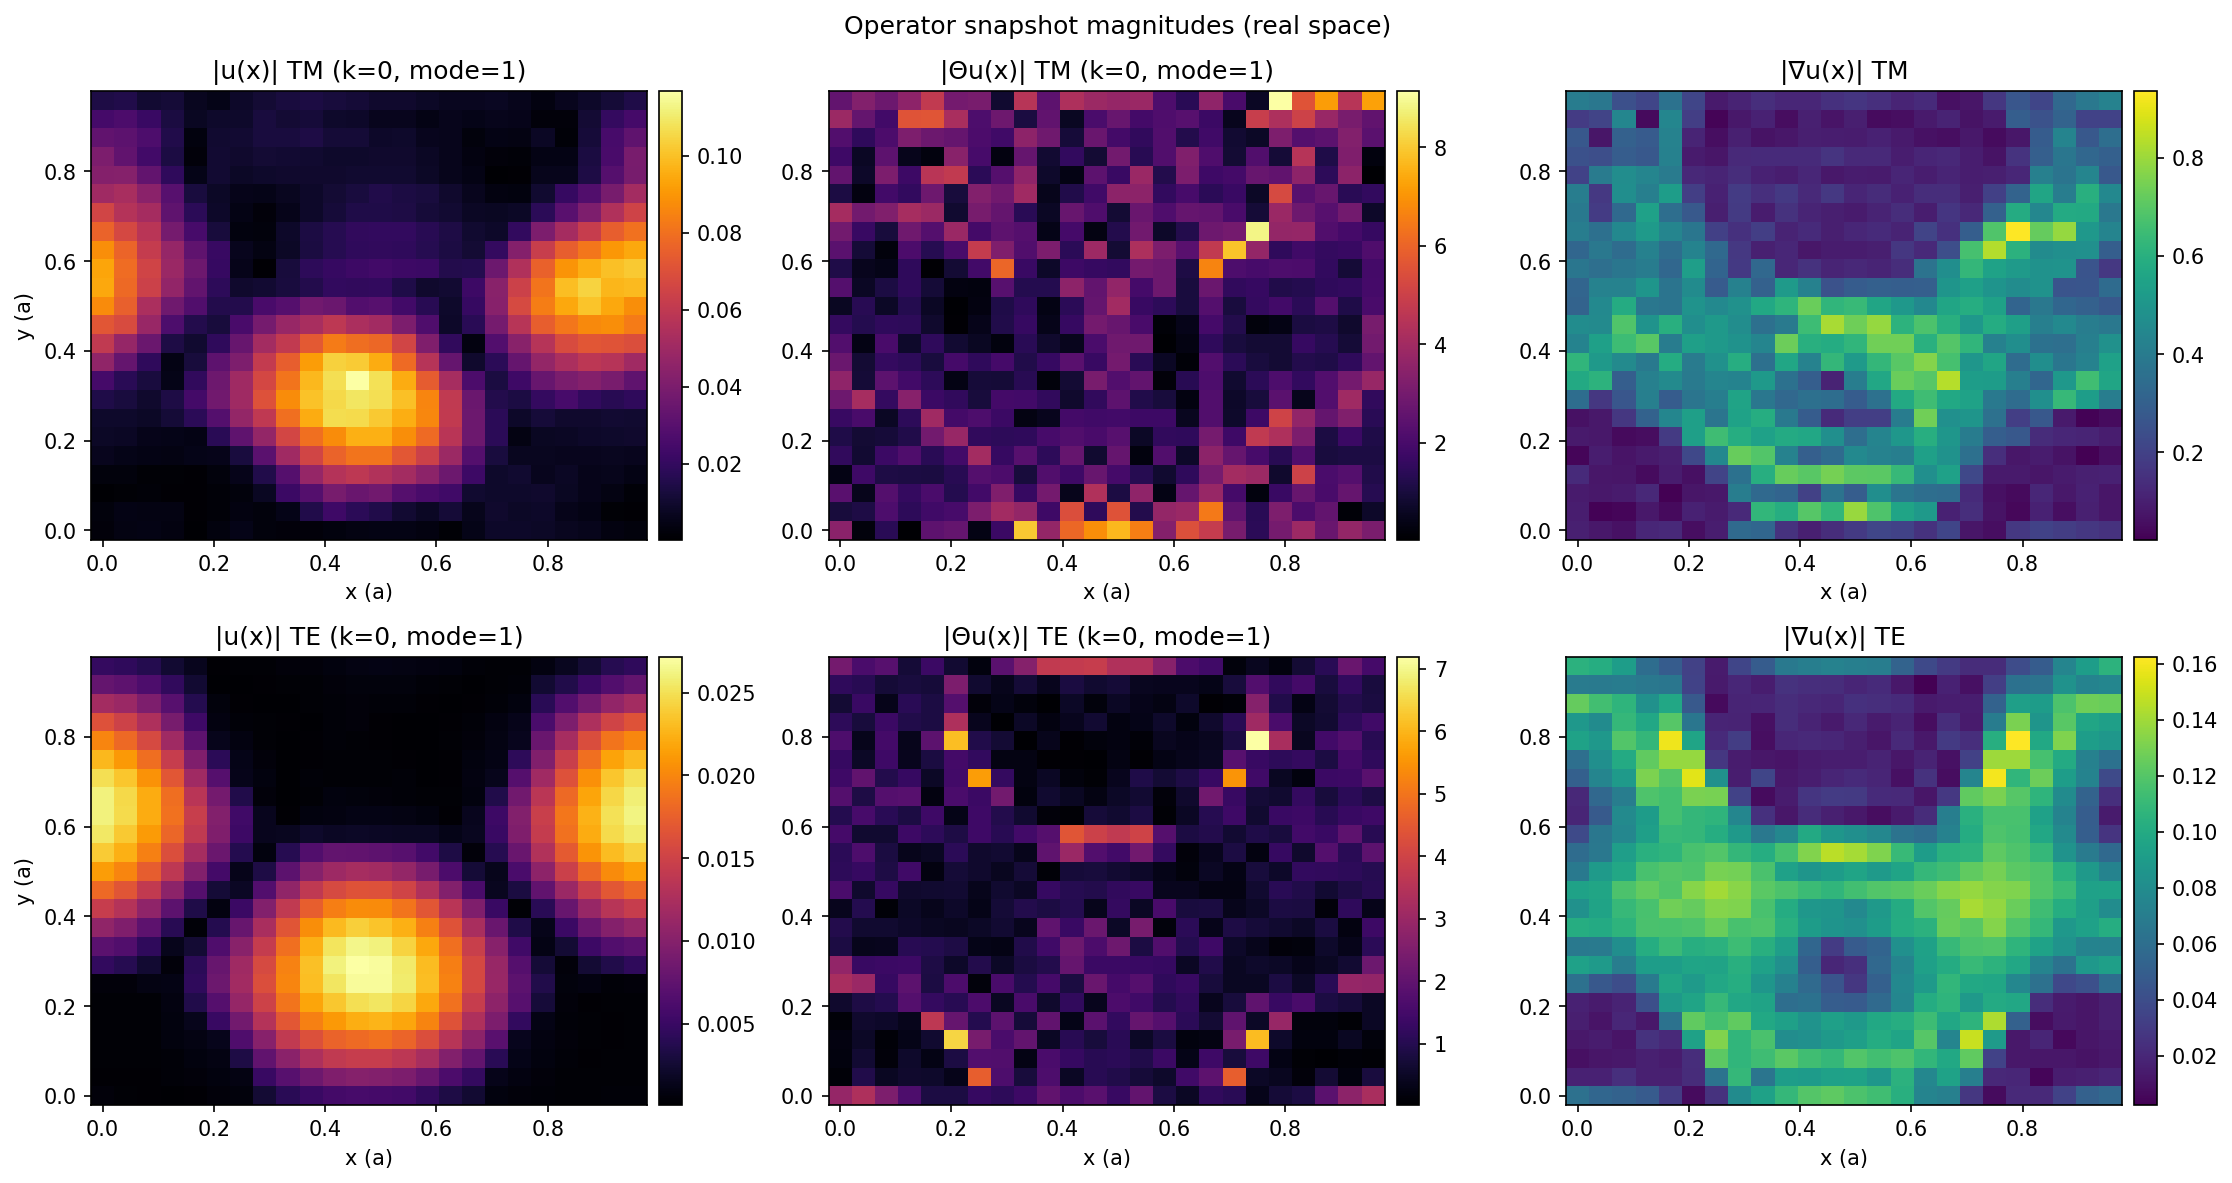

In [9]:
DEFAULT_OPERATOR_TARGETS = {
    "TM": {"k_index": 0, "mode_index": 1},
    "TE": {"k_index": 0, "mode_index": 1},
}

snapshot_payload = {}
for pol, target in DEFAULT_OPERATOR_TARGETS.items():
    try:
        df = load_operator_snapshot(pol, target["k_index"], target["mode_index"])
    except FileNotFoundError:
        continue
    df = df.copy()
    df["field_mag"] = np.hypot(df["re_field"], df["im_field"])
    df["theta_mag"] = np.hypot(df["re_theta"], df["im_theta"])
    grad_columns = {"re_grad_x", "im_grad_x", "re_grad_y", "im_grad_y"}
    grad_available = grad_columns.issubset(df.columns)
    if grad_available:
        grad_x = df["re_grad_x"].to_numpy() + 1j * df["im_grad_x"].to_numpy()
        grad_y = df["re_grad_y"].to_numpy() + 1j * df["im_grad_y"].to_numpy()
        df["grad_mag"] = np.sqrt(np.abs(grad_x) ** 2 + np.abs(grad_y) ** 2)
    else:
        df["grad_mag"] = np.nan
    xs = _axis_coords(df, "ix", "x")
    ys = _axis_coords(df, "iy", "y")
    snapshot_payload[pol] = {
        "xs": xs,
        "ys": ys,
        "field": _reshape_grid(df, "field_mag"),
        "theta": _reshape_grid(df, "theta_mag"),
        "grad": _reshape_grid(df, "grad_mag") if grad_available else None,
        "k_index": target["k_index"],
        "mode_index": target["mode_index"],
        "k_frac": (float(df["k_frac_x"].iat[0]), float(df["k_frac_y"].iat[0])),
    }

if not snapshot_payload:
    print("No operator_snapshot CSVs found. Run mpb2d-cli with --dump-pipeline to capture them.")
else:
    plot_pols = [pol for pol in ["TM", "TE"] if pol in snapshot_payload]
    has_grad = any(payload["grad"] is not None for payload in snapshot_payload.values())
    ncols = 3 if has_grad else 2
    fig, axes = plt.subplots(len(plot_pols), ncols, figsize=(5 * ncols, 4 * len(plot_pols)), dpi=150)
    if len(plot_pols) == 1:
        axes = np.expand_dims(axes, axis=0)
    for row_idx, pol in enumerate(plot_pols):
        payload = snapshot_payload[pol]
        grids = [payload["field"], payload["theta"]]
        titles = ["|u(x)|", "|Θu(x)|"]
        for col_idx, (grid, title) in enumerate(zip(grids, titles)):
            ax = axes[row_idx, col_idx]
            mesh = ax.pcolormesh(payload["xs"], payload["ys"], grid, shading="nearest", cmap="inferno")
            ax.set_title(f"{title} {pol} (k={payload['k_index']}, mode={payload['mode_index']})")
            ax.set_xlabel("x (a)")
            if col_idx == 0:
                ax.set_ylabel("y (a)")
            fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.02)
        if has_grad:
            ax = axes[row_idx, 2]
            if payload["grad"] is None:
                ax.text(0.5, 0.5, "∇ data unavailable", ha="center", va="center")
                ax.set_axis_off()
            else:
                mesh = ax.pcolormesh(payload["xs"], payload["ys"], payload["grad"], shading="nearest", cmap="viridis")
                ax.set_title(f"|∇u(x)| {pol}")
                ax.set_xlabel("x (a)")
                fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.02)
    fig.suptitle("Operator snapshot magnitudes (real space)")
    fig.tight_layout()
    plt.show()

/tmp/ipykernel_11474/2002789483.py:30: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax.pcolormesh(payload["kx"], payload["ky"], grid, shading="nearest", cmap="magma")


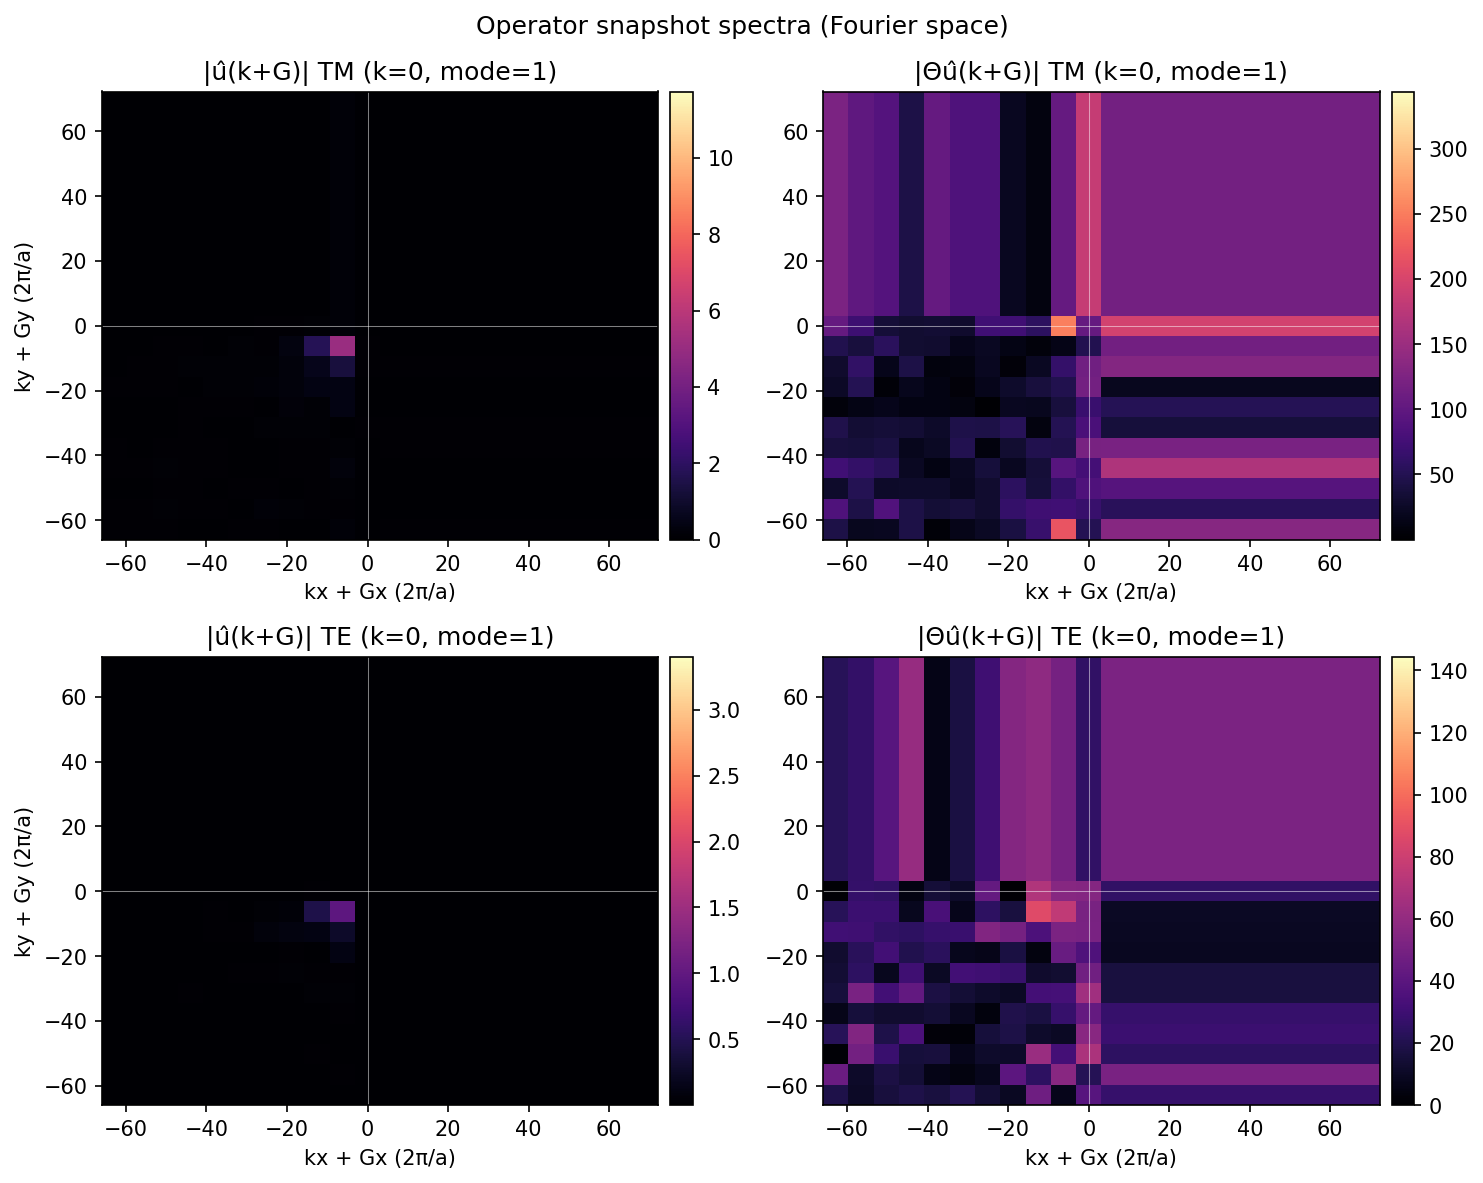

In [10]:
spectra_payload = {}
for pol, target in DEFAULT_OPERATOR_TARGETS.items():
    try:
        df = load_operator_spectrum(pol, target["k_index"], target["mode_index"])
    except FileNotFoundError:
        continue
    df = df.copy()
    spectra_payload[pol] = {
        "kx": _axis_coords(df, "ix", "kx_plus_g"),
        "ky": _axis_coords(df, "iy", "ky_plus_g"),
        "field": _reshape_grid(df, "field_hat_mag"),
        "theta": _reshape_grid(df, "theta_hat_mag"),
        "k_index": target["k_index"],
        "mode_index": target["mode_index"],
    }

if not spectra_payload:
    print("No operator_spectrum CSVs found yet.")
else:
    plot_pols = [pol for pol in ["TM", "TE"] if pol in spectra_payload]
    fig, axes = plt.subplots(len(plot_pols), 2, figsize=(10, 4 * len(plot_pols)), dpi=150)
    if len(plot_pols) == 1:
        axes = np.expand_dims(axes, axis=0)
    for row_idx, pol in enumerate(plot_pols):
        payload = spectra_payload[pol]
        grids = [payload["field"], payload["theta"]]
        titles = ["|û(k+G)|", "|Θû(k+G)|"]
        for col_idx, (grid, title) in enumerate(zip(grids, titles)):
            ax = axes[row_idx, col_idx]
            mesh = ax.pcolormesh(payload["kx"], payload["ky"], grid, shading="nearest", cmap="magma")
            ax.set_title(f"{title} {pol} (k={payload['k_index']}, mode={payload['mode_index']})")
            ax.set_xlabel("kx + Gx (2π/a)")
            if col_idx == 0:
                ax.set_ylabel("ky + Gy (2π/a)")
            ax.axhline(0.0, color="white", linewidth=0.5, alpha=0.5)
            ax.axvline(0.0, color="white", linewidth=0.5, alpha=0.5)
            fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.02)
    fig.suptitle("Operator snapshot spectra (Fourier space)")
    fig.tight_layout()
    plt.show()

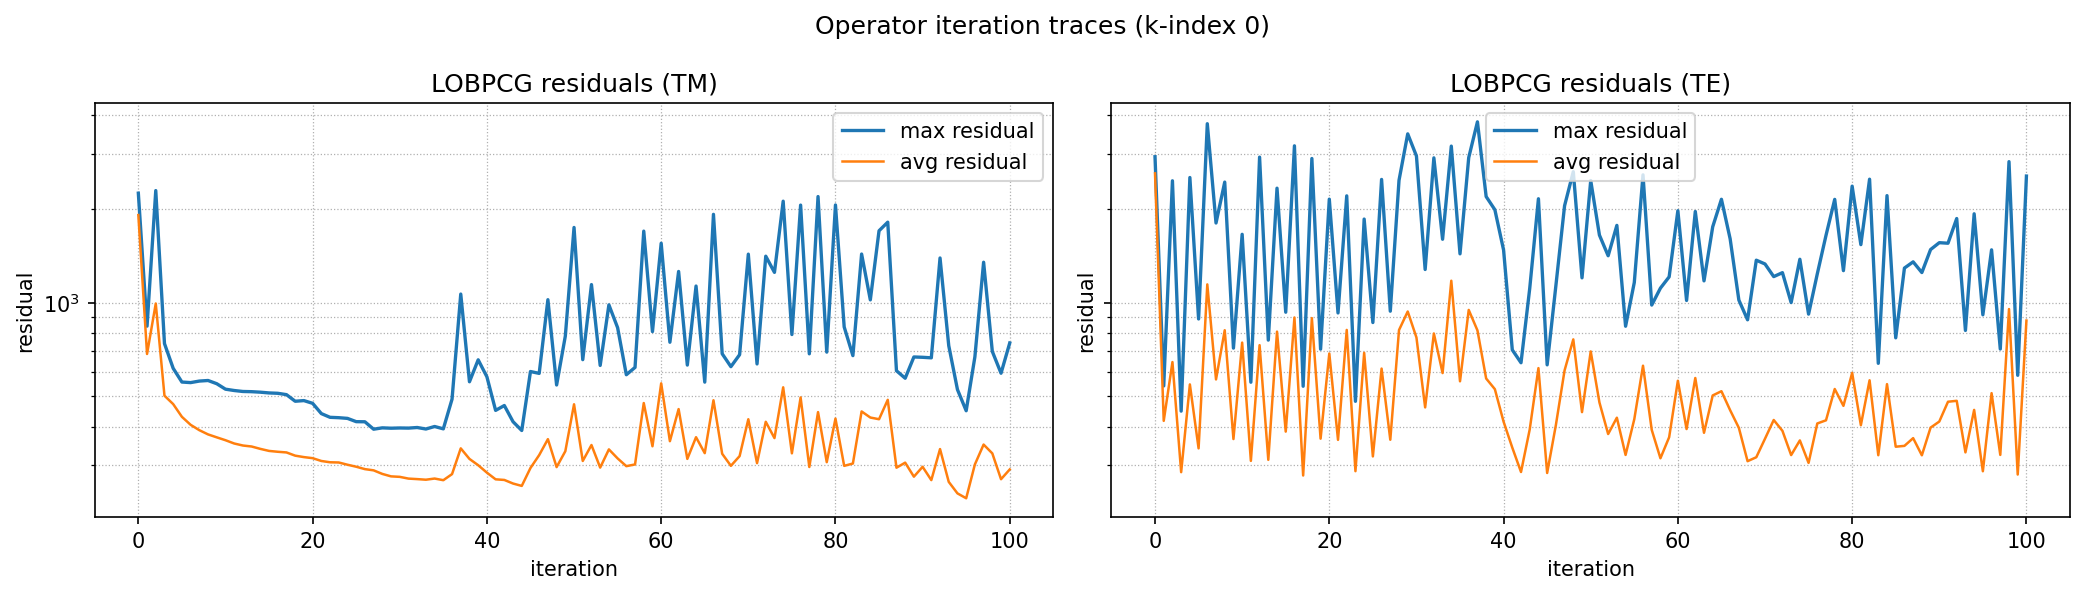

,iterations,final_max_residual,final_avg_residual,block_size_last,new_directions_last,preconditioner_trials
pol,,,,,,
TM,101,742.4732,291.2940,10,10,1010
TE,101,2552.8470,876.3639,10,10,1010


In [11]:
iteration_traces = {}
for pol in ["TM", "TE"]:
    try:
        iteration_traces[pol] = load_iteration_trace(pol, k_index=0)
    except FileNotFoundError:
        continue

if not iteration_traces:
    print("No operator_iteration_trace CSVs found.")
else:
    fig, axes = plt.subplots(1, len(iteration_traces), figsize=(7 * len(iteration_traces), 4), dpi=150, sharey=True)
    if len(iteration_traces) == 1:
        axes = [axes]
    for ax, pol in zip(axes, iteration_traces.keys()):
        df = iteration_traces[pol]
        ax.semilogy(df["iteration"], df["max_residual"], label="max residual", linewidth=1.6)
        ax.semilogy(df["iteration"], df["avg_residual"], label="avg residual", linewidth=1.2)
        ax.set_title(f"LOBPCG residuals ({pol})")
        ax.set_xlabel("iteration")
        ax.set_ylabel("residual")
        ax.grid(True, which="both", linestyle=":", linewidth=0.6)
        ax.legend()
    fig.suptitle("Operator iteration traces (k-index 0)")
    fig.tight_layout()
    plt.show()

    summary_rows = []
    for pol, df in iteration_traces.items():
        summary_rows.append({
            "pol": pol,
            "iterations": len(df),
            "final_max_residual": df["max_residual"].abs().iloc[-1],
            "final_avg_residual": df["avg_residual"].abs().iloc[-1],
            "block_size_last": int(df["block_size"].iloc[-1]),
            "new_directions_last": int(df["new_directions"].iloc[-1]),
            "preconditioner_trials": int(df["preconditioner_trials"].sum()),
        })
    summary_df = pd.DataFrame(summary_rows).set_index("pol")
    try:
        display(summary_df.style.format({
            "final_max_residual": "{:.3e}",
            "final_avg_residual": "{:.3e}",
        }))
    except Exception:
        display(summary_df)

/tmp/ipykernel_11474/1216790570.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax.pcolormesh(kx, ky, grid, shading="nearest", cmap="magma")
/tmp/ipykernel_11474/1216790570.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax.pcolormesh(kx, ky, grid, shading="nearest", cmap="magma")


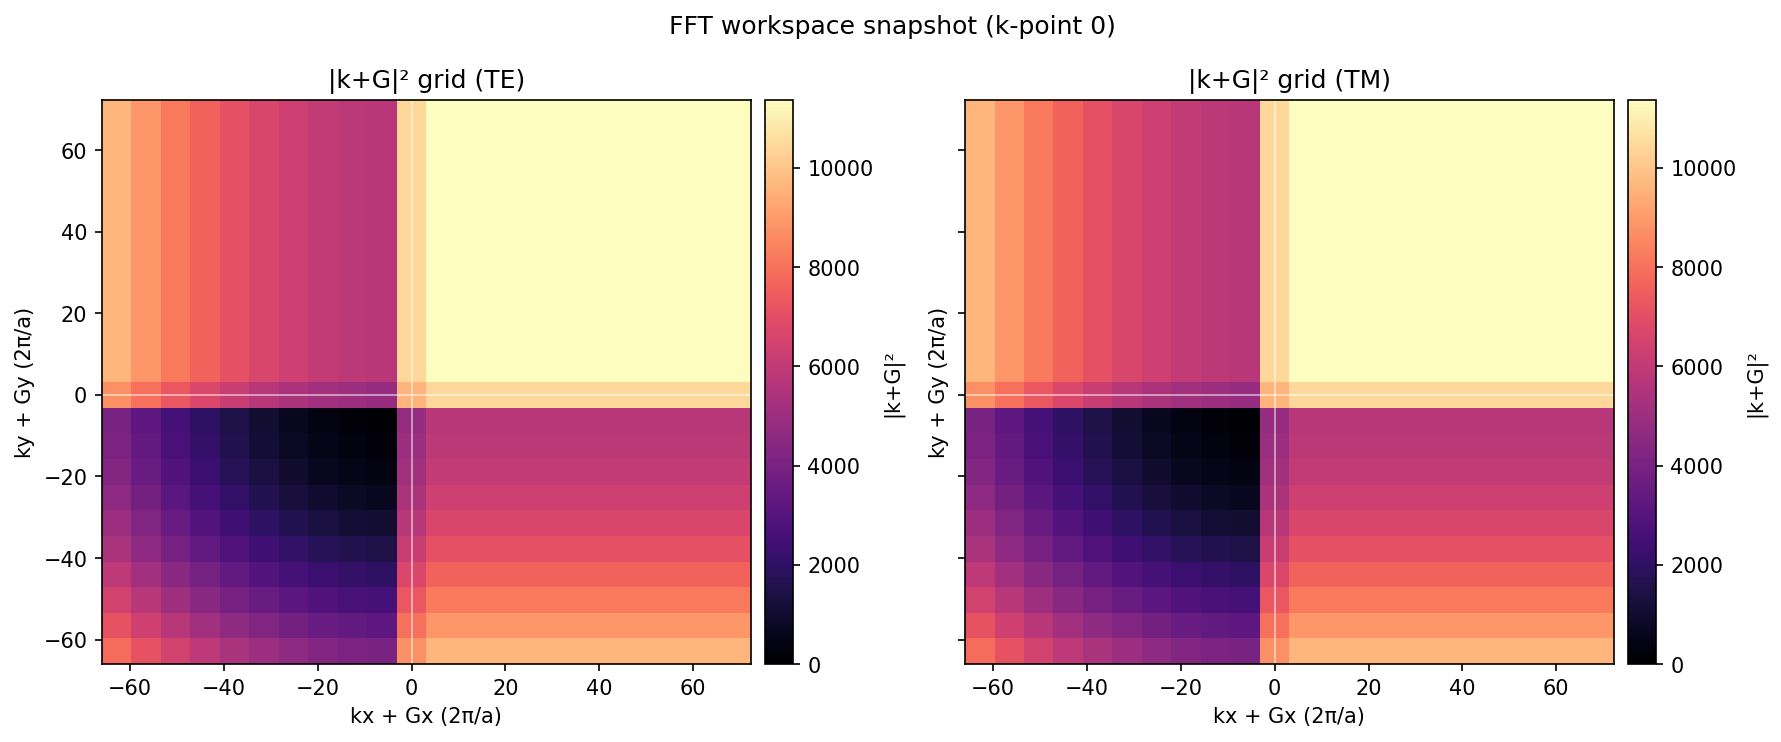

In [12]:
fft_workspace_raw = {}
for pol in ["TM", "TE"]:
    try:
        df = load_fft_workspace_raw(pol)
    except FileNotFoundError:
        continue
    fft_workspace_raw[pol] = df

if not fft_workspace_raw:
    print("No fft_workspace_raw_k000.csv artifacts found. Run mpb2d-cli with --dump-pipeline first.")
else:
    fig, axes = plt.subplots(1, len(fft_workspace_raw), figsize=(6 * len(fft_workspace_raw), 5), dpi=150, sharex=True, sharey=True)
    if len(fft_workspace_raw) == 1:
        axes = [axes]
    for ax, (pol, df) in zip(axes, sorted(fft_workspace_raw.items())):
        grid = _reshape_grid(df, "k_plus_g_sq")
        kx = _axis_coords(df, "ix", "kx_plus_g")
        ky = _axis_coords(df, "iy", "ky_plus_g")
        mesh = ax.pcolormesh(kx, ky, grid, shading="nearest", cmap="magma")
        ax.set_title(f"|k+G|² grid ({pol})")
        ax.set_xlabel("kx + Gx (2π/a)")
        ax.set_ylabel("ky + Gy (2π/a)")
        ax.axhline(0.0, color="white", linewidth=0.8, alpha=0.6)
        ax.axvline(0.0, color="white", linewidth=0.8, alpha=0.6)
        fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.02, label="|k+G|²")
    fig.suptitle("FFT workspace snapshot (k-point 0)")
    fig.tight_layout()
    plt.show()

In [13]:
fft_workspace_reports = {}
for pol in ["TM", "TE"]:
    try:
        fft_workspace_reports[pol] = load_fft_workspace_report(pol)
    except FileNotFoundError:
        continue

if not fft_workspace_reports:
    print("No fft_workspace_report_k000.json artifacts found. Run mpb2d-cli with --dump-pipeline first.")
else:
    rows = []
    for pol, report in sorted(fft_workspace_reports.items()):
        bloch = report.get("bloch_vector", {})
        k_stats = report.get("k_plus_g_sq", {})
        workspace = report.get("workspace_buffers", {})
        mem_mb = workspace.get("bytes_total", 0) / (1024**2)
        rows.append(
            {
                "pol": pol,
                "k_frac": (report.get("k_fractional", {}).get("kx"), report.get("k_fractional", {}).get("ky")),
                "|k| norm": bloch.get("norm"),
                "|k+G|² min": k_stats.get("min"),
                "|k+G|² max": k_stats.get("max"),
                "|k+G|² mean": k_stats.get("mean"),
                "mesh_size": report.get("dielectric_mesh_size"),
                "buffers": workspace.get("count"),
                "bytes_total": workspace.get("bytes_total"),
                "approx_MB": mem_mb,
            }
        )
    summary_df = pd.DataFrame(rows).set_index("pol")

    try:
        display(
            summary_df.style.format(
                {
                    "|k| norm": "{:.3f}",
                    "|k+G|² min": "{:.3f}",
                    "|k+G|² max": "{:.3f}",
                    "|k+G|² mean": "{:.3f}",
                    "approx_MB": "{:.2f}",
                }
            )
        )
    except Exception as exc:
        print("Styler unavailable (install jinja2 for HTML output); showing rounded table instead.")
        display(summary_df.round({"|k| norm": 3, "|k+G|² min": 3, "|k+G|² max": 3, "|k+G|² mean": 3, "approx_MB": 2}))

    if len(summary_df) == 2:
        delta = summary_df.loc["TE", "|k+G|² mean"] - summary_df.loc["TM", "|k+G|² mean"]
        print(f"Δ mean(|k+G|²) (TE - TM): {delta:.3f}")


Styler unavailable (install jinja2 for HTML output); showing rounded table instead.


,k_frac,|k| norm,|k+G|² min,|k+G|² max,|k+G|² mean,mesh_size,buffers,bytes_total,approx_MB
pol,,,,,,,,,
TE,"(0.0, 0.0)",0.0,0.0,11369.784,3803.088,4,3,27648,0.03
TM,"(0.0, 0.0)",0.0,0.0,11369.784,3803.088,4,3,27648,0.03


Δ mean(|k+G|²) (TE - TM): 0.000
